# Benchmark of manifold CAC algorithm on TSP


Next steps:

1) Tune parameters

2) Add annealing

3) Test on QAP

4) Accelerate dynamics by doing approximate / sparse gradient ?


(suppose we only keep x>0 and do sparse MVM, complexity could be linear in N)

In [15]:
using DelimitedFiles
using Statistics

include("lib.jl")
include("manifoldCAC.jl")


run_ODE (generic function with 1 method)

In [2]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames

In [3]:
folder = "./TSP_benchmark/"

# Create the folder if it does not exist
if !isdir(folder)
    mkdir(folder)
    println("Folder created: $folder")
end


## Generation of random TSP instances

In [4]:
N_list = [5,8,10]    # size of the TSP
n = 10   # number of instances

10

In [5]:

if false
    
    for N in N_list
        
        for i in 1:n
        
            #generate random TSP distance matrix
            D = generate_tsp_distance_matrix(N, true)
            
            #brute force its ground-state
            H, H0 = brute_force(N,D)
            
            # Write the matrix to the file
            file_path = joinpath(folder, "rTSP_D_$(N)_$(i).dat")
            file_path_H0 = joinpath(folder, "rTSP_H0_$(N)_$(i).dat")
            writedlm(file_path, D, ' ')  # Using space as a delimiter
            writedlm(file_path_H0, H0, ' ')  # Using space as a delimiter
        
            println("Generated TSP $(i) with N=$(N)")
            
        end
    
    end

end

In [6]:
## Run algorithm

In [7]:
# 0) parameters of the solver

steps = 500
beta0 = 0.1
lambda = 0.1
gamma = 10.0

K = 10 #nb of trajectories to evaluate success probability per instance


10

In [8]:

p0_mat = []
t0_mat = []
tCPU_mat = []

for N in N_list

    p0_list = []
    t0_list = []
    tCPU_list = []

    M₀ = UnitaryMatrices(N, ℝ)
            
    for i in 1:n

        # 1) setup the instance
        D, H0 = load_TSP_instance(N,i)
        
        cost_fnc_P, cost_fnc_X, T, b = initialize_solver(N,D)

        isolved_list = []
        t0_l = []
        tCPU_l = []
        
        for k in 1:K

            # 2) initialize
            
            tspan = (0.0,steps)
            beta = beta0 / mean((2*b) .* T * D)
            params = (D, T, steps, beta, lambda, gamma,b)

            # 3) run
            isolved, t0, tCPU, H, H_perm, sol = run_ODE(N,params,tspan,M₀,cost_fnc_X,H0)

            push!(isolved_list, isolved)
            push!(t0_l, t0)
            push!(tCPU_l, tCPU)

            if isolved
                println("Run TSP, trial $(k), instance $(i), N=$(N), found solution at t0=$(t0) ; after $(tCPU) s.")
            else
                println("Run TSP, trial $(k), instance $(i), N=$(N), solution not found ; after $(tCPU) s.")

            end
           
        end

        push!(p0_list, mean(isolved_list))
        push!(t0_list, mean(t0_l))
        push!(tCPU_list, mean(tCPU_l))

    end

    push!(p0_mat, p0_list)
    push!(t0_mat, t0_list)
    push!(tCPU_mat, tCPU_list)

end

Run TSP, trial 1, instance 1, N=5, found solution at t0=20.991221634138867 ; after 6.8540525 s.
Run TSP, trial 2, instance 1, N=5, solution not found ; after 0.0318443 s.
Run TSP, trial 3, instance 1, N=5, found solution at t0=88.78614521848715 ; after 0.0644729 s.
Run TSP, trial 4, instance 1, N=5, found solution at t0=26.849604850773513 ; after 0.0213345 s.
Run TSP, trial 5, instance 1, N=5, solution not found ; after 0.044748 s.
Run TSP, trial 6, instance 1, N=5, solution not found ; after 0.0455795 s.
Run TSP, trial 7, instance 1, N=5, solution not found ; after 0.0127173 s.
Run TSP, trial 8, instance 1, N=5, found solution at t0=23.309460763392657 ; after 0.0264614 s.
Run TSP, trial 9, instance 1, N=5, solution not found ; after 0.0410908 s.
Run TSP, trial 10, instance 1, N=5, found solution at t0=22.125019770249803 ; after 0.0473746 s.
Run TSP, trial 1, instance 2, N=5, solution not found ; after 0.0625083 s.
Run TSP, trial 2, instance 2, N=5, solution not found ; after 0.0498928

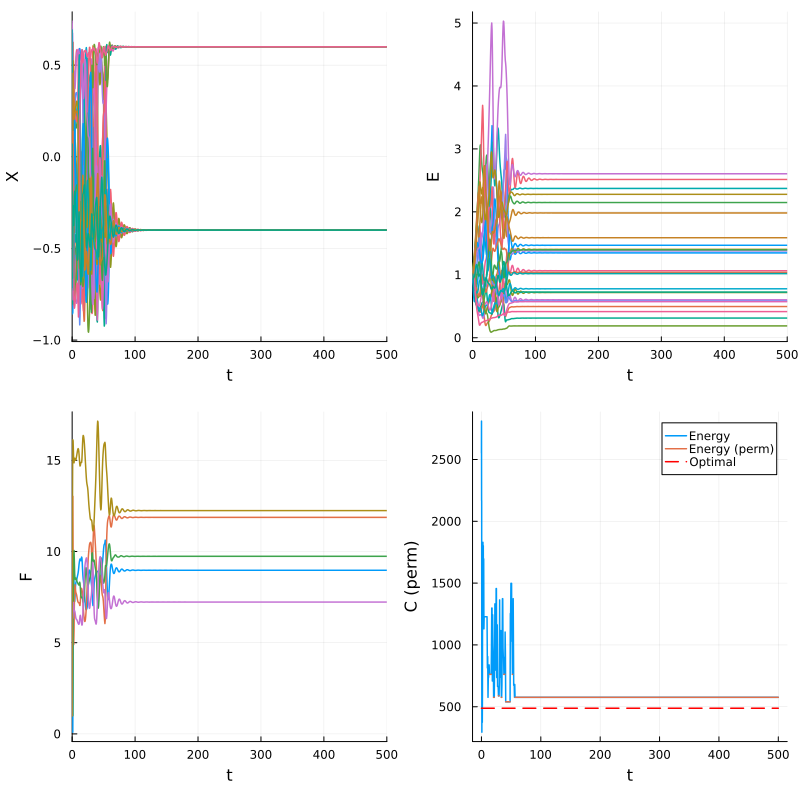

In [9]:
#plot trajectory

if true

    N = 5
    i = 1
    
    M₀ = UnitaryMatrices(N, ℝ)
    
    D, H0 = load_TSP_instance(N,i)
        
    cost_fnc_P, cost_fnc_X, T, b = initialize_solver(N,D)

    tspan = (0.0,steps)
    beta = beta0 / mean((2*b) .* T * D)
    params = (D, T, steps, beta, lambda, gamma,b)

    # 3) run
    isolved, t0, tCPU, H, H_perm, sol = run_ODE(N,params,tspan,M₀,cost_fnc_X,H0)


    #4) plot
    
    p = plot(layout=(2, 2), size=(800, 800))

    plot!(p[1], sol, idxs=1:N^2, plotdensity=1000, lw=1.5, legend=false, ylabel="X")
    
    plot!(p[2],sol, idxs=(N^2+1):(2*N^2), plotdensity=1000, lw=1.5, legend=false , ylabel="E")
    #plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)
    
    plot!(p[3],sol, idxs=(2*N^2+1):(2*N^2+N), plotdensity=1000, lw=1.5, legend=false, ylabel="F")
    #plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)
    
    plot!(p[4],sol.t,H , label="Energy", lw=1.5, xlabel="t", ylabel="C")
    plot!(p[4],sol.t,H_perm , label="Energy (perm)", lw=1.5, xlabel="t", ylabel="C (perm)")
    plot!(p[4],sol.t,fill(H0, length(sol.t)), label="Optimal", lw=1.5, xlabel="t",color=:red, linestyle=:dash)

    if isolved
        plot!(p[4],[t0,t0],[minimum(H),maximum(H)], label="Optimal", lw=1.5, xlabel="t0",color=:black, linestyle=:dash)
    end

    display(p)
    #savefig(p, "example.png")

end

In [10]:
p0_mat

3-element Vector{Any}:
 Any[0.5, 0.4, 0.6, 0.5, 0.5, 0.4, 0.5, 0.7, 0.4, 0.6]
 Any[0.1, 0.3, 0.4, 0.1, 0.3, 0.1, 0.2, 0.1, 0.2, 0.0]
 Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [11]:
t0_mat

3-element Vector{Any}:
 Any[268.20614522370414, 312.1561641914788, 220.5508896924839, 257.86219223884575, 271.52698389828157, 311.4743317210691, 266.4562632918702, 166.88872049385387, 323.95286648544726, 227.704744890796]
 Any[460.8225655683609, 460.5361514363607, 438.262417603421, 485.1125153823884, 444.0595630405263, 464.33369332225845, 456.5492225961798, 483.89435607947723, 446.33696200483394, 500.0]
 Any[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]

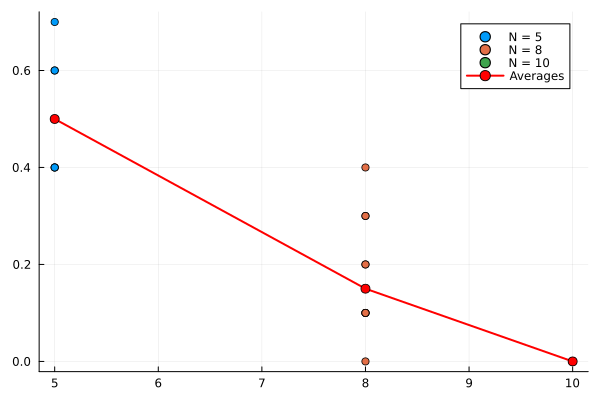

In [12]:
if true

    p = scatter()
    
    for (i, vec) in enumerate(p0_mat)
        x_values = repeat([N_list[i]], length(vec))  # X-axis value for each dot is the index in N_list
        scatter!(x_values, vec, label = "N = $(N_list[i])")  # Add scatter points for each vector
    end

    # Calculate the averages of each vector in p0_mat
    averages = [median(vec) for vec in p0_mat]
    
    # Plot a line linking the averages
    plot!(N_list, averages, label = "Averages", lw=2, color=:red, marker=:circle, markersize=5)

    display(p)
    
end

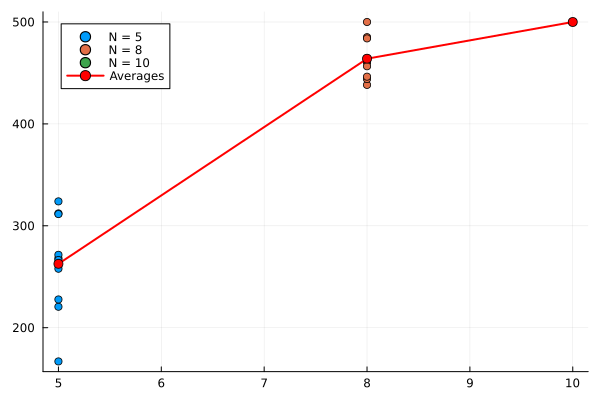

In [17]:
if true

    p = scatter()
    
    for (i, vec) in enumerate(t0_mat)
        x_values = repeat([N_list[i]], length(vec))  # X-axis value for each dot is the index in N_list
        scatter!(x_values, vec, label = "N = $(N_list[i])")  # Add scatter points for each vector
    end

    # Calculate the averages of each vector in t0_mat
    averages = [mean(vec) for vec in t0_mat]
    
    # Plot a line linking the averages
    plot!(N_list, averages, label = "Averages", lw=2, color=:red, marker=:circle, markersize=5)

    display(p)
    
end

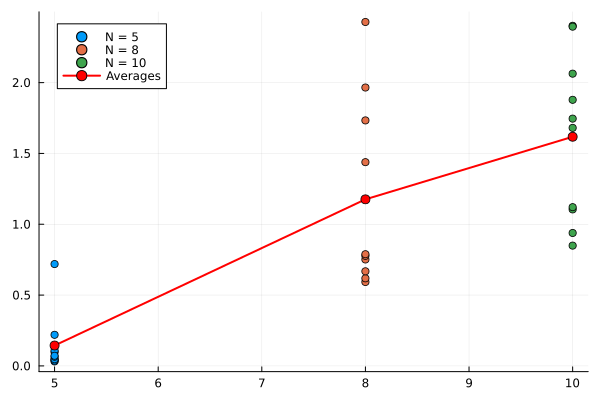

In [14]:
if true

    p = scatter()
    
    for (i, vec) in enumerate(tCPU_mat)
        x_values = repeat([N_list[i]], length(vec))  # X-axis value for each dot is the index in N_list
        scatter!(x_values, vec, label = "N = $(N_list[i])")  # Add scatter points for each vector
    end

    # Calculate the averages of each vector in tCPU_mat
    averages = [mean(vec) for vec in tCPU_mat]
    
    # Plot a line linking the averages
    plot!(N_list, averages, label = "Averages", lw=2, color=:red, marker=:circle, markersize=5)

    display(p)
    
end